In [26]:
import pandas as pd
from nltk.corpus import stopwords
from nltk import WordNetLemmatizer
import string
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
from matplotlib import pyplot as plt

PATH = 'Indeed/data'

In [50]:
stop_words = stopwords.words('english')
stop = set(stop_words)
stop.add("miss")

exclude = set(string.punctuation)
lemma = WordNetLemmatizer()         # 词干化

In [54]:
def clean(text):
    if text == "MISS":
        return ' '
    stop_free = " ".join([i for i in text.lower().split() if i not in stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    return normalized


train_data = pd.read_csv(PATH + '/train.csv').dropna(subset=['text', 'cons', 'pros'])
dev_data = pd.read_csv(PATH + '/dev.csv').dropna(subset=['text', 'cons', 'pros'])
test_data = pd.read_csv(PATH + '/dev.csv').dropna(subset=['text', 'cons', 'pros'])

## 只使用总结性描述 text

In [31]:
train_text = [clean(text) for text in train_data.loc[:]['text']]
dev_text = [clean(text) for text in dev_data.loc[:]['text']]
test_text = [clean(text) for text in test_data.loc[:]['text']]

In [32]:
print(train_data.shape, dev_data.shape, test_data.shape)

(676028, 26) (85381, 26) (85381, 26)


In [13]:
# 文本由三个部分组成，总结性描述text，缺点描述cons, 优点描述pros
train_data[['text', 'cons', 'pros', 'overall_rating']].head()

,text,cons,pros,overall_rating
0,"As an International Student Product Engineer, ...",distant management,wonderful interaction with other facilities,4
1,I supported patients by providing housekeeping...,MISS,MISS,5
2,Working environment is pleasant and up lifting...,Gov. contracting bids are main bread and butter.,"Free Coffee, award fees for job well done",4
3,Installation und Inbetriebnahme von Anlagen.rn...,Arbeitszeiten,Firmenwagen,4
4,pretty good place but does not offer many hour...,MISS,MISS,3


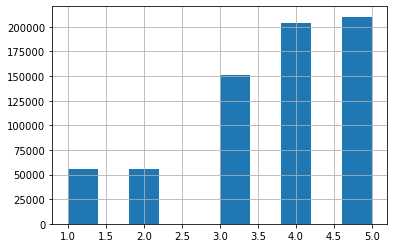

In [14]:
train_data['overall_rating'].hist()

***
**tf-idf Transformer**

In [33]:
tfidf_transformer = TfidfVectorizer(ngram_range=(1, 2), max_features=100000)

In [34]:
X_train = tfidf_transformer.fit_transform(train_text)
X_test = tfidf_transformer.transform(test_text)
X_dev = tfidf_transformer.transform(dev_text)

In [35]:
Y_train = train_data['overall_rating']
Y_dev = dev_data['overall_rating']
Y_test = test_data['overall_rating']

In [36]:
X_train.shape

(676028, 100000)

***
**定义模型用于多分类，多项式分布的朴素贝叶斯和逻辑斯谛克回归**

In [81]:
from sklearn.linear_model import LogisticRegression
from sklearn import naive_bayes
from sklearn import metrics
from sklearn import linear_model
from sklearn import svm
from collections import Counter
import time
from multiprocessing import cpu_count


def modelNB(trainX, trainY, testX, testY):
    clf = naive_bayes.MultinomialNB()
    clf.fit(trainX, trainY)
    predsTest = clf.predict(testX)
    predsTrain = clf.predict(trainX)
    
    acc = metrics.accuracy_score(testY, predsTest)
    report = metrics.classification_report(testY, predsTest, target_names=[str(i+1) for i in range(5)], digits=4)
    confusion = metrics.confusion_matrix(testY, predsTest)
    print('多项式分布的朴素贝叶斯 test --------')
    print(round(acc,4))
    print(report)
    print(confusion)
    
    
def modelLogit(trainX, trainY, testX, testY):
    clf = LogisticRegression(penalty='l2', C=1)
    clf.fit(trainX, trainY)

    predsTest = clf.predict(testX)
    predsTrain = clf.predict(trainX)

    acc = metrics.accuracy_score(testY, predsTest)
    report = metrics.classification_report(testY, predsTest, target_names=[str(i+1) for i in range(5)], digits=4)
    confusion = metrics.confusion_matrix(testY, predsTest)
    print('Logistic regression test -------')
    print(round(acc,4))
    print(report)
    print(confusion)

def modelSVM(trainX, trainY, testX, testY):
    clf = svm.SVC(kernel='linear', C=1.6)
    clf.fit(trainX, trainY)

    predsTest = clf.predict(testX)
    predsTrain = clf.predict(trainX)

    print('线性核SVM test -------')
    acc = metrics.accuracy_score(testY, predsTest)
    report = metrics.classification_report(testY, predsTest, target_names=[str(i+1) for i in range(5)], digits=4)
    confusion = metrics.confusion_matrix(testY, predsTest)
    print(round(acc,4))
    print(report)
    print(confusion)

In [40]:
t0 = time.time()
modelLogit(X_train, Y_train, X_test, Y_test)
print()
print(time.time() - t0)

E:\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Logistic regression test -------
0.4779
              precision    recall  f1-score   support

           1     0.5599    0.5308    0.5450      6991
           2     0.4145    0.1505    0.2209      7121
           3     0.4202    0.4122    0.4162     19131
           4     0.4308    0.4420    0.4363     25595
           5     0.5403    0.6339    0.5834     26543

    accuracy                         0.4779     85381
   macro avg     0.4731    0.4339    0.4403     85381
weighted avg     0.4717    0.4779    0.4684     85381

[[ 3711   565  1739   560   416]
 [ 1480  1072  2764  1133   672]
 [ 1015   705  7886  5831  3694]
 [  266   176  4307 11312  9534]
 [  156    68  2071  7423 16825]]

71.3605842590332


In [41]:
t0 = time.time()
modelNB(X_train, Y_train, X_test, Y_test)
print()
print(time.time() - t0)

高斯分布的朴素贝叶斯 test --------
0.4772
              precision    recall  f1-score   support

           1     0.5252    0.5569    0.5405      6991
           2     0.5833    0.0875    0.1522      7121
           3     0.4121    0.4306    0.4211     19131
           4     0.4280    0.4602    0.4435     25595
           5     0.5518    0.6109    0.5798     26543

    accuracy                         0.4772     85381
   macro avg     0.5001    0.4292    0.4274     85381
weighted avg     0.4838    0.4772    0.4645     85381

[[ 3893   192  1910   564   432]
 [ 1703   623  3028  1177   590]
 [ 1290   179  8238  6030  3394]
 [  340    57  4663 11778  8757]
 [  187    17  2152  7971 16216]]

0.6911783218383789


## 使用总结性描述、缺点描述和优点描述

In [66]:
train_text = [clean(text) for text in train_data.loc[:]['text']]
dev_text = [clean(text) for text in dev_data.loc[:]['text']]
test_text = [clean(text) for text in test_data.loc[:]['text']]

train_cons_text = [clean(text) for text in train_data.loc[:]['cons']]
train_pros_text = [clean(text) for text in train_data.loc[:]['pros']]

dev_cons_text = [clean(text) for text in dev_data.loc[:]['cons']]
dev_pros_text = [clean(text) for text in dev_data.loc[:]['pros']]

test_cons_text = [clean(text) for text in test_data.loc[:]['cons']]
test_pros_text = [clean(text) for text in test_data.loc[:]['pros']]


In [67]:
train_text = [train_text[ii] + ' ' + train_cons_text[ii] + ' ' + train_pros_text[ii] for ii in range(len(train_text))]
dev_text = [dev_text[ii] + ' ' + dev_cons_text[ii] + ' ' + dev_pros_text[ii] for ii in range(len(dev_text))]
test_text = [test_text[ii] + ' ' + test_cons_text[ii] + ' ' + test_pros_text[ii] for ii in range(len(test_text))]

In [69]:
len(train_text)

676028

In [77]:
tfidf_transformer = TfidfVectorizer(ngram_range=(1, 2), max_features=100000)

In [78]:
X_train = tfidf_transformer.fit_transform(train_text)
X_test = tfidf_transformer.transform(test_text)
X_dev = tfidf_transformer.transform(dev_text)

In [79]:
t0 = time.time()
modelLogit(X_train, Y_train, X_test, Y_test)
print()
print(time.time() - t0)

E:\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Logistic regression test -------
0.4847
              precision    recall  f1-score   support

           1     0.5621    0.5534    0.5577      6991
           2     0.4189    0.1628    0.2344      7121
           3     0.4241    0.4272    0.4256     19131
           4     0.4360    0.4540    0.4448     25595
           5     0.5557    0.6242    0.5879     26543

    accuracy                         0.4847     85381
   macro avg     0.4794    0.4443    0.4501     85381
weighted avg     0.4795    0.4847    0.4767     85381

[[ 3869   612  1636   479   395]
 [ 1586  1159  2716  1069   591]
 [ 1031   751  8172  5803  3374]
 [  259   165  4665 11620  8886]
 [  138    80  2078  7680 16567]]

79.37677812576294


In [82]:
t0 = time.time()
modelNB(X_train, Y_train, X_test, Y_test)
print()
print(time.time() - t0)

多项式分布的朴素贝叶斯 test --------
0.4824
              precision    recall  f1-score   support

           1     0.5389    0.5612    0.5498      6991
           2     0.5871    0.0918    0.1588      7121
           3     0.4151    0.4380    0.4263     19131
           4     0.4323    0.4745    0.4524     25595
           5     0.5603    0.6060    0.5823     26543

    accuracy                         0.4824     85381
   macro avg     0.5068    0.4343    0.4339     85381
weighted avg     0.4899    0.4824    0.4704     85381

[[ 3923   211  1928   516   413]
 [ 1677   654  3108  1117   565]
 [ 1197   188  8380  6128  3238]
 [  307    51  4685 12145  8407]
 [  175    10  2086  8186 16086]]

0.7566533088684082
